# MA6202: Laboratorio de Ciencia de Datos

**Profesor: Nicolás Caro**\
**Auxiliar: Rodrigo Lara M**

**17/05/2020 - Tarea 1**


**Integrantes del grupo**: Pablo Araya Z., Fabian Badilla M.

## 1 Introducción
La siguiente evaluación corresponde a la primera tarea del curso de laboratorio de ciencia de datos. A modo de contexto, se trabajará con un conjunto de datos, en el cual se busca una estimación del precio por metro cuadrado para viviendas en la ciudad de Bogotá, se busca además de una estimación de incertidumbre en predicción.\
Para ello, se proporcionan datos recolectados por _web-scrapping_ y una serie de estadísticas que caracterizan determinadas zonas geográficas de interés, llamadas Unidades de Planeación Zonal (UPZ).

Las condiciones de entrega requeridas son:

* La extensión máxima de el informe es de 6 planas a las que puede añadir 2 para demostraciones.
* Debe adjuntar un repositorio `git` donde se incluya todo su código.
* A lo menos 1 `commit` por cada pregunta de la tarea
* Por lo menos 1 `merge` a través de su trabajo.
* Incluya un documento `jupyter notebook` llamado `tarea1.ipynb` en el cual se exponga todo el procedimiento realizado.
* Por último es necesario también entregar un archivo _pickle_ denominado `modelo.pk` que contenga el último modelo de regresión entrenado.

Tenga en mente que su informe será revisado por un equipo técnico que debe entender a cabalidad su metodología, ser capaz de replicarlo y evaluarlo a partir de la lectura de este.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, sys
import warnings
from IPython.display import clear_output,display_html
import missingno as msno
from sklearn.base import RegressorMixin, BaseEstimator

warnings.filterwarnings('ignore')

## P1. Carga y limpieza de datos
En la presente sección se realizan los pasos de carga y limpieza de datos que permitirán realizar las secciones
posteriores con un `DataFrame` consolidado que presente los tipos de datos adecuados para la información contenida
en sus columnas.\
Incluya en el reporte todas las decisiones que llevó en esta seccion, ademas de reportar y discutir acerca de
los aspectos específicos señalados en cada pregunta.

1. Los datos recolectados en la carpeta `data/raw` están divididos en carpetas con el formato `wNN` donde `NN` corresponde a la semana del año en la que estos fueron consultados. Cargue los datos en un solo `DataFrame` y elimine las filas duplicadas. Además genere una variable categórica en la que se indique si la observación correspondiente proviene de un archivo que en su nombre contiene `'furnished'`\
(ejemplo: metrocuadrado_furnished_wNN.csv).\
**Hint:** para lo último puede ser útil estudiar los argumentos del
método `pd.merge`. Reporte si existen observaciones de archivos con texto `'furnished'` que no estén contenidos en archivos con texto `'all'`.

In [2]:
''' Se juntan los dfs de los csv con nombre "all" '''
df_s = []
for i in range(13,18):
    w = "w"+str(i)
    direccion = 'data/raw/'+w+'/metrocuadrado_all_'+w+'.csv'
    df = pd.read_csv(direccion)
    df_s.append(df)
df_all = pd.concat(df_s,axis=0,ignore_index = True)

'''Creamos la variable categorica'''
df_all['Archivo'] = 'all'

''' Eliminamos los datos duplicados'''
df_all.drop_duplicates(inplace=True,ignore_index=True)

''' Se juntan los dfs de los csv con nombre "furnished" '''
df_s = []
for i in range(13,18):
    w = "w"+str(i)
    direccion = 'data/raw/'+w+'/metrocuadrado_furnished_'+w+'.csv'
    df = pd.read_csv(direccion)
    df_s.append(df)
df_fur = pd.concat(df_s,axis=0,ignore_index = True)

'''Creamos la variable categorica'''
df_fur['Archivo'] = 'furnished'

''' Eliminamos los datos duplicados'''
df_fur.drop_duplicates(inplace=True,ignore_index=True)

''' Juntamos los dos dfs'''
df = pd.concat([df_all,df_fur],axis=0,ignore_index = True)

''' Eliminamos posibles datos de furnished que esten en all'''
df.drop_duplicates(['property_type|rent_type|location', 'price', 'n_rooms', 'n_bath','surface', 'details',
                    'url', 'metrocuadrado_index'],inplace=True,ignore_index=True)

print('Hay',sum(df['Archivo']=='furnished'),'Observaciones de furnished que no estan contenidas en all')

Hay 2099 Observaciones de furnished que no estan contenidas en all


2. Limpie las columnas:
    1. Precio y de área del inmueble, número de habitaciones y número de baños.
    2. De `'property type|rent type|location'`. Debe obtener 3 columnas en las que se detalle el tipo de inmueble (casa o apartamento), el tipo de la oferta (arriendo o arriendo y venta) además de el barrio en el cual se ubica el inmueble (texto en mayúsculas para la mayoría de los casos) Llame a esta última columna `'location'`.\
    __Hint:__ Para ello pueden ser útiles los métodos `str.split` y `str.strip` de la clase `pd.Series`.

In [3]:
''' Quitamos los nan '''
df = df.dropna(axis = 0)#,subset=['price','n_rooms','n_bath','surface'])
df.reset_index(drop=True,inplace=True)

''' Limpiamos los datos de price y surface '''
df['price'] = [x.replace('$','') for x in df['price']]
df['price'] = [x.replace('.','') for x in df['price']]
df['price'] = df['price'].astype('float64')
df['surface'] = [x.replace(' m2','') for x in df['surface']]
df['surface'] = df['surface'].astype('float64')

''' Cambiar el formato de los datos n_bath y n_rooms'''
for i in range(len(df['n_bath'])):
    if type(df['n_bath'][i]) == float:
        df['n_bath'][i] = str(int(df['n_bath'][i]))
        
for i in range(len(df['n_rooms'])):
    if type(df['n_rooms'][i]) == float:
        df['n_rooms'][i] = str(int(df['n_rooms'][i]))
            
df.dtypes

property_type|rent_type|location     object
price                               float64
n_rooms                              object
n_bath                               object
surface                             float64
details                              object
url                                  object
metrocuadrado_index                 float64
Archivo                              object
dtype: object

In [4]:
''' Separar la primera columna en las 3 columnas respectivas'''

columna = 'property_type|rent_type|location'
first_col = df[columna]
first_col = pd.Series([x.replace(' ',',', 1) for x in first_col])
first_col = first_col.str.split(pat=',',expand =True)
first_col.columns = columna.split('|')
first_col['rent_type'] =  [x.replace('en ','') for x in first_col['rent_type']]
df = pd.concat([first_col,df.iloc[:,1:]],axis=1)
df['location'] = [x.replace(' ','', 1) for x in df['location']]

3. Adjunte las siguientes columnas:
    1. Genere una variable que represente el precio por metro cuadrado.
    2. Obtenga el número de garajes procesando la columna `'url'` .

In [5]:
''' Se genera la nueva columna del precio por metro cuadrado'''
df['Precio_m2'] = df['price']/df['surface']

In [6]:
''' Generar la columna del numero de garajes'''
num_gar = []
for x in df['url']:
    if '-garajes' not in x:
        num_gar.append('0')
    else:
        num_gar.append(x[x.find('banos-')+6:x.find('-garajes')])
df['Numero_Garajes'] = num_gar

4. Clasifique las observaciones por tipo de producto de acuerdo a los criterios de la Tabla
    1. Hint: puede ser útil el método `query` de `pd.DataFrame`

|Tipo de Producto| Tipo de Inmueble| área min | área max |
|----------------|-----------------|----------|----------|
|        1       |       casa      | 80       |    <120  |
|        2       |       casa      | 120      |    <180  |
|        3       |       casa      | 180      |    <240  |
|        4       |       casa      | 240      |    <360  |
|        5       |       casa      | 360      |    460   |
|        6       |   apartamento   | 40       |    <60   |
|        7       |   apartamento   | 60       |    <80   |
|        8       |   apartamento   | 80       |    120   |

In [7]:
''' Generar el tipo de producto segun la condicion'''

condiciones = ['80<=surface<120 and property_type=="Casa"','120<=surface<180 and property_type=="Casa"',
              '180<=surface<240 and property_type=="Casa"','240<=surface<360 and property_type=="Casa"',
              '360<=surface<=460 and property_type=="Casa"','40<=surface<60 and property_type=="Apartamento"',
              '60<=surface<80 and property_type=="Apartamento"','80<=surface<=120 and property_type=="Apartamento"']
df['tipo_producto'] = np.zeros(len(df))
for i in range(1,9):
    ind = df.query(condiciones[i-1]).index
    df.loc[ind,'tipo_producto']=int(i) 

In [8]:
mal_indice = df[df['tipo_producto']==0].index
buen_indice = [x for x in df.index if x not in mal_indice]
df = df.loc[buen_indice]

5. A partir de la columna `'barrio'`, haga una fusión con el archivo `data/assignacion upz/barrio-upz-asignacion.csv` para obtener así el código de la UPZ de cada inmueble. Reporte el numero de observaciones y de barrios a los que no se les puede adjuntar un código UPZ a partir de este archivo. Tenga en cuenta que aproximadamente 90% de los datos tiene información sobre UPZ.

In [9]:
'''Cargamos los datos'''
barrio_upz =pd.read_csv('data/asignacion_upz/barrio-upz.csv')
barrio_upz.drop(['UPlTipo','UPlNombre'], axis=1, inplace=True)

''' Para realizar lo anterior hay que limpiar la columna location'''
df['location'] =  [x.replace(' Bogotá D.C..','') for x in df['location']]
df['location'] =df['location'].str.lower()

''' Cambiamos el nombre de la columna para poder juntar los df '''
barrio_upz.rename(columns={"pro_location": "location"},inplace = True)

'''Juntamos los data frames'''
df = pd.merge(df,barrio_upz,how ='left',on ='location')

''' Reporte de a cuantos barrios no les pudo asignar codigo'''
num_nan = df['UPlCodigo'].isna().sum()
por_nan = 100-df['UPlCodigo'].isna().sum()*100/len(df)
print('N° Observaciones sin codigo:',num_nan)
print('% Observacions sin codigo:',por_nan.round(3))

N° Observaciones sin codigo: 1640
% Observacions sin codigo: 89.346


6. En la carpeta `data/estadisticas_upz` encontraría todos los archivos que debe fusionar con su `DataFrame`, a través del código de UPZ, para así enriquecer su conjunto de datos con estadísticas de población, socioeconómicas y de calidad de vida a nivel de UPZ. Una vez realizada la fusión, adjunte una nueva columna con la densidad de población por UPZ.

In [10]:
''' Cargamos los 3 csv'''
esta = pd.read_csv('data/estadisticas_upz/estadisticas_poblacion.csv',index_col = 0)
ind = pd.read_csv('data/estadisticas_upz/indice_inseguridad.csv',index_col = 0)
porct = pd.read_csv('data/estadisticas_upz/porcentaje_areas_verdes.csv',index_col = 0)

''' Cambiamos los datos para poder hacer el merge'''
esta.rename(columns={"upz": "UPlCodigo"},inplace = True)
porct.rename(columns={"cod_upz": "UPlCodigo"},inplace = True)
porct['UPlCodigo']= porct['UPlCodigo'].apply(int)
porct['UPlCodigo'] = ['UPZ'+str(x) for x in porct['UPlCodigo']]

''' Juntamos los dfs '''
df = pd.merge(df,esta,how ='left',on ='UPlCodigo')
df = pd.merge(df,ind,how ='left',on ='UPlCodigo')
df = pd.merge(df,porct,how ='left',on ='UPlCodigo')

In [11]:
''' Generar la densidad poblacional por UPZ'''
df['Density'] = df['personas']/df['UPlArea']

In [12]:
'''Se borran columnas repetidas o que no aportan info util'''
df.drop(['nomupz','UPlNombre2','url','details','upz'], axis=1, inplace=True)
df.rename(columns={"upz": "UPlNombre"},inplace = True)
df.to_pickle('./data/data.pkl')

In [13]:
for col in ['Precio_m2','surface']:
    q = df[col].quantile(0.98)
    df=df[df[col] < q]

In [14]:
df_s = df.dropna(axis=0)

## P2. EDA
En la siguiente pregunta utilice el `DataFrame` obtenido a partir de los procedimientos anteriores. La idea central del presente ejercicio es analizar la base de datos que fue construida realizando un análisis exploratorio de datos (EDA) riguroso que permite obtener información útil para la parte final de tarea. Para cada pregunta y considerando que la variable de respuesta es el precio por metro cuadrado, discuta sus resultados y reporte algunos gráficos interesantes en su informe.

1. Programe una función `estilo()` que aplica un estilo de gráficos por defecto diseñado por usted. Este estilo debe ser empleado en todos los gráficos que incluya en su informe.\
__Hint:__ Use métodos de la librería `seaborn` para ello.

In [12]:
def estilo():
    miestilo= { 'axes.edgecolor': 'black',
                'axes.axisbelow': True,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'patch.edgecolor':'none',
                'patch.force_edgecolor': False,
                'axes.spines.right': False,
                'axes.spines.top': False, 
                }
    sns.set(style='darkgrid', rc=miestilo)
    
estilo()

2. Perfile las variables obtenidas en su `DataFrame`, agrúpelas y analícelas según su naturaleza. En función de su agrupación, grafíque las distribuciones dando un tratamiento adecuado a cada tipo de variable, discuta ciertos casos de interés.

In [13]:
'''Se carga el dataset limpiado'''
df=pd.read_pickle('./data/data.pkl')

'''
Se separan las columnas en variables numericas, ordinales y categoricas. 
Se formatean como float64, int y str respectivamente:
'''
Numericas = ['price', 'surface', 'metrocuadrado_index', 
       'Precio_m2',  'UPlArea','personas','trabajoinf_ninos_5_17_anos_perc',
       'trabajoinfampliado_ninos_5_17_anos_perc', 'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento',
       'jefe_mujer_perc', 'adultos_mayores_pobres_perc', 'indice_inseguridad', 'areas_verdes_perc', 'Density']

Ordinales = ['Numero_Garajes','n_bath','n_rooms','tipo_producto']
Categoricas = list(set(df.columns) - set(Numericas) - set(Ordinales))
Numericas.sort()
Categoricas.sort()
Ordinales.sort()

'''Se eliminan algunas observaciones para poder transformar'''
df=df[df.Numero_Garajes!='4+'] #9 obs
df=df[df.n_rooms!='5+'] #8 obs
df=df[df.n_bath!='5+']  #7 obs

df = df.astype({col:'str' for col in Categoricas})
df = df.astype({col:'int' for col in Ordinales})
df = df.astype({col:'float64' for col in Numericas})

mapping = [('Numericas', col) for col in Numericas]
mapping.extend([('Categoricas', col) for col in Categoricas])
mapping.extend([('Ordinales', col) for col in Ordinales])

df = df.reindex(columns=Numericas + Categoricas + Ordinales)
df.columns = pd.MultiIndex.from_tuples(mapping)

df.to_pickle('./data/data_perfilada.pkl')

'''No considero outliers de algunas columnas (solucion por ahora)'''
for col in ['Precio_m2','surface']:
    q = df.Numericas[col].quantile(0.99)
    df=df[df.Numericas[col] < q]

Usaremos un esquema similar para graficar asi que se define la siguiente funcion:

In [14]:
def distribucion(tipo, lista, df=df):
    nrows=int(len(lista) / 3) + (len(lista) % 3 > 0)
    ncols=3
    lista.sort()
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[5*ncols, min(5*nrows, 17)])
    fig.tight_layout()
    n=int(nrows*ncols - len(lista))
    if n>0:
        if nrows>1:
            list(map(lambda a : a.remove(), ax[-1,-n:]))
        else:
            list(map(lambda a : a.remove(), ax[-n:]))
    fig.suptitle('Distribuciones Univariadas '+tipo ,fontsize=24,x=0.5,y=1.05)    
    if tipo!='Numericas':
        for axis, col in zip(ax.flatten(), lista):
            sns.countplot(df[(tipo,col)], ax=axis, palette='colorblind', 
                          order=np.unique(df[(tipo,col)]))
            axis.set_xlabel(col, fontsize=15)
            if col in ['UPlCodigo','UPlNombre','UPlArea','location']:
                axis.get_xaxis().set_ticks([])
        h, w = (.3, .2)
        plt.subplots_adjust(wspace=w, hspace=h)
        fig.savefig('./fig/'+tipo+'.pdf', bbox_inches='tight')
    else:
        for axis, col in zip(ax.flatten(), lista):
            sns.distplot(df[(tipo, col)], ax=axis, rug=True, color='purple')
            axis.set_xlabel(col, fontsize=15)
            if col in ['UPlArea']:
                axis.get_xaxis().set_ticks([])

        w, h = (.3, .3)
        plt.subplots_adjust(wspace=w, hspace=h)
        fig.savefig('./fig/'+tipo+'.pdf', bbox_inches='tight')
        
def interes(tipo,lista, df=df):
    nrows=int(len(lista) / 3) + (len(lista) % 3 > 0)
    ncols=3
    lista.sort()
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[5*ncols, min(5*nrows,17)])
    fig.tight_layout()
    n=int(nrows*ncols - len(lista))
    if n>0:
        if nrows>1:
            list(map(lambda a : a.remove(), ax[-1,-n:]))
        else:
            list(map(lambda a : a.remove(), ax[-n:]))
    fig.suptitle('Variables '+tipo+' de Interes',fontsize=24,x=0.5,y=1.05)
    if tipo!='Numericas':
        for axis, col in zip(ax.flatten(), lista):
            sns.violinplot(x=(tipo,col),y=('Numericas','Precio_m2'),data=df,kind='violin',ax=axis,
                           palette='colorblind', order=np.unique(df[(tipo,col)]))
            axis.set_xlabel(col, fontsize=15)
            axis.set_ylabel('Precio por m²', fontsize=15)
        h, w = (.3, .3)
        plt.subplots_adjust(wspace=w, hspace=h)
        fig.savefig('./fig/'+tipo+'_interes.pdf', bbox_inches='tight')
    else:
        for axis, col in zip(ax.flatten(), num_interes):
            sns.regplot(x=df[(tipo, col)],
                        y=df[('Numericas', 'Precio_m2')],
                        ax=axis, 
                        color='purple', 
                        scatter_kws={'alpha':0.05})
            axis.set_xlabel(col)
            axis.set_ylabel('Precio_m2')
            if col in ['UPlArea']:
                axis.get_xaxis().set_ticks([])
        w, h = (.25, .3)
        plt.subplots_adjust(wspace=w, hspace=h)
        fig.savefig('./fig/'+tipo+'_interes.png', bbox_inches='tight')

## Variables Categóricas

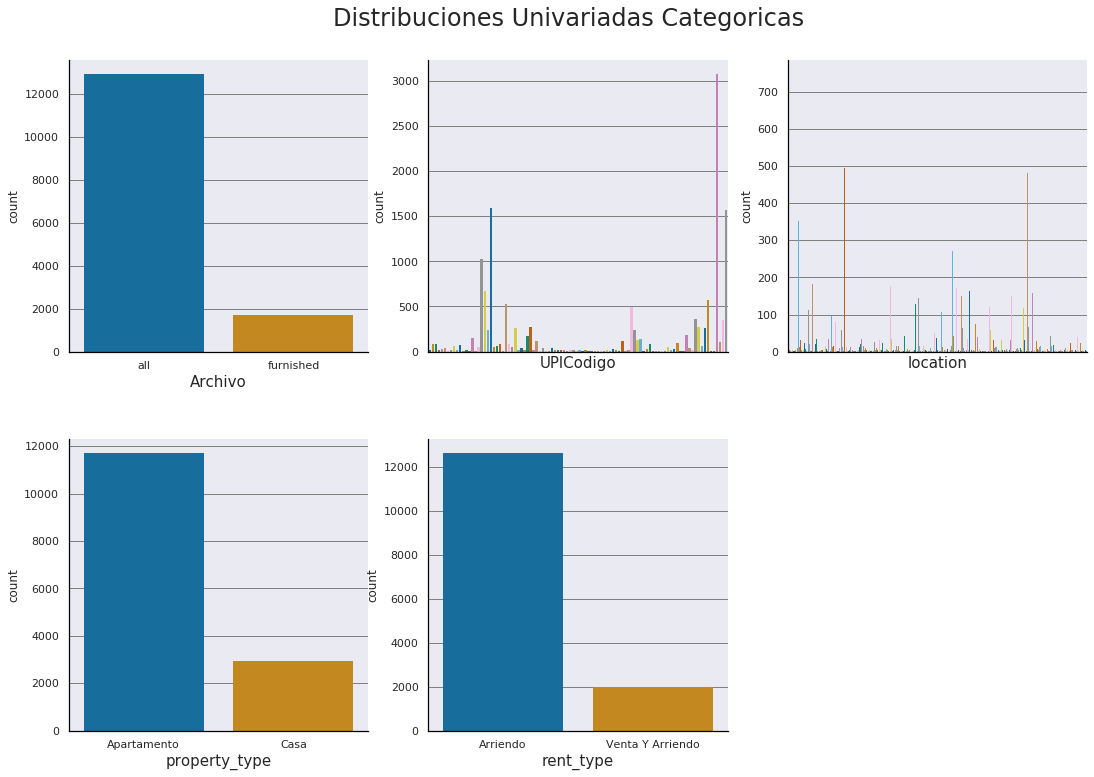

In [15]:
Categoricas.remove('UPlNombre') #Tendra la misma distribucion que UPlCodigo, asi que no aporta verla
distribucion('Categoricas', Categoricas)

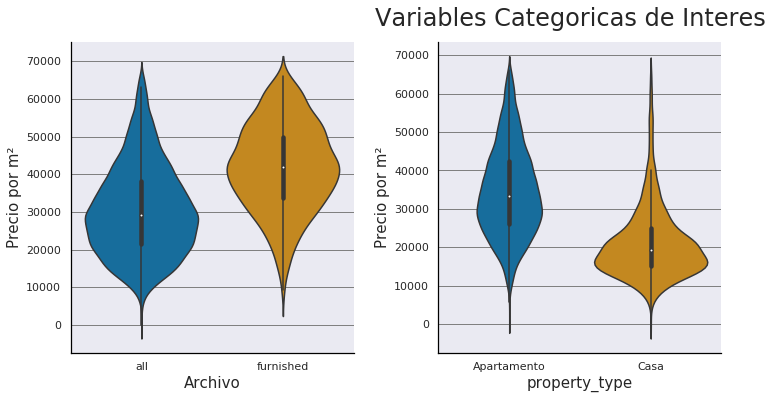

In [16]:
cat_interes=Categoricas.copy()
for d in ['UPlCodigo', 'location', 'rent_type']:
    cat_interes.remove(d)
interes('Categoricas', cat_interes)

## Variables Ordinales

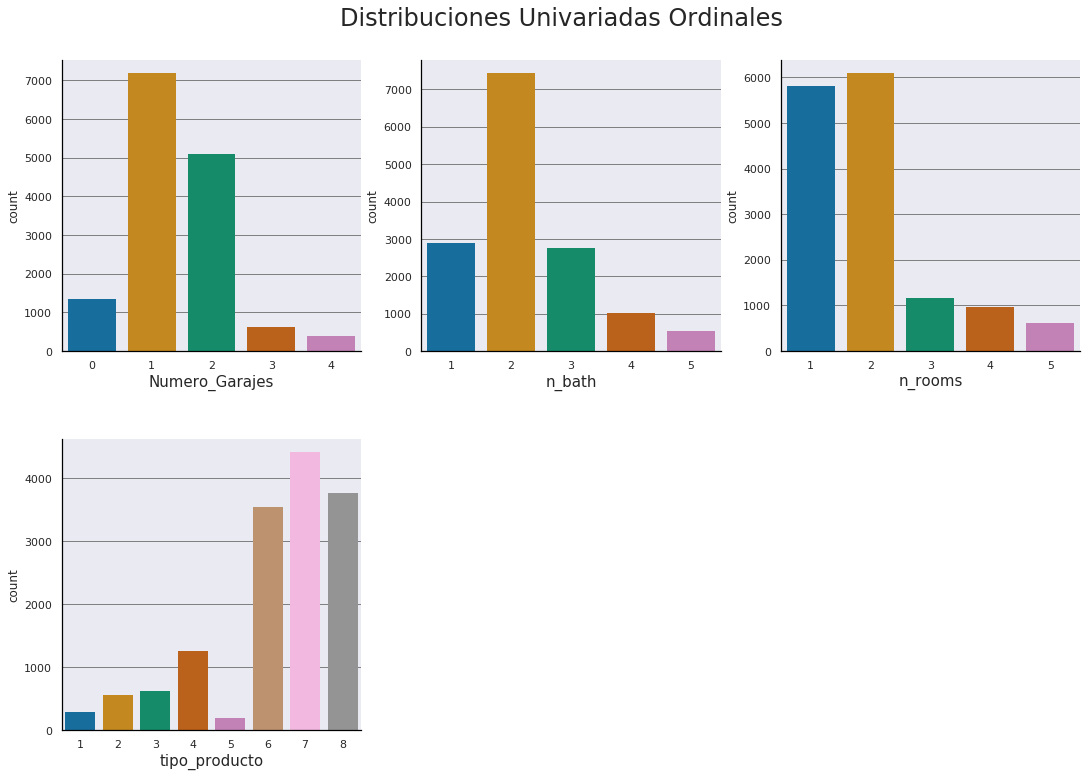

In [17]:
distribucion('Ordinales', Ordinales)

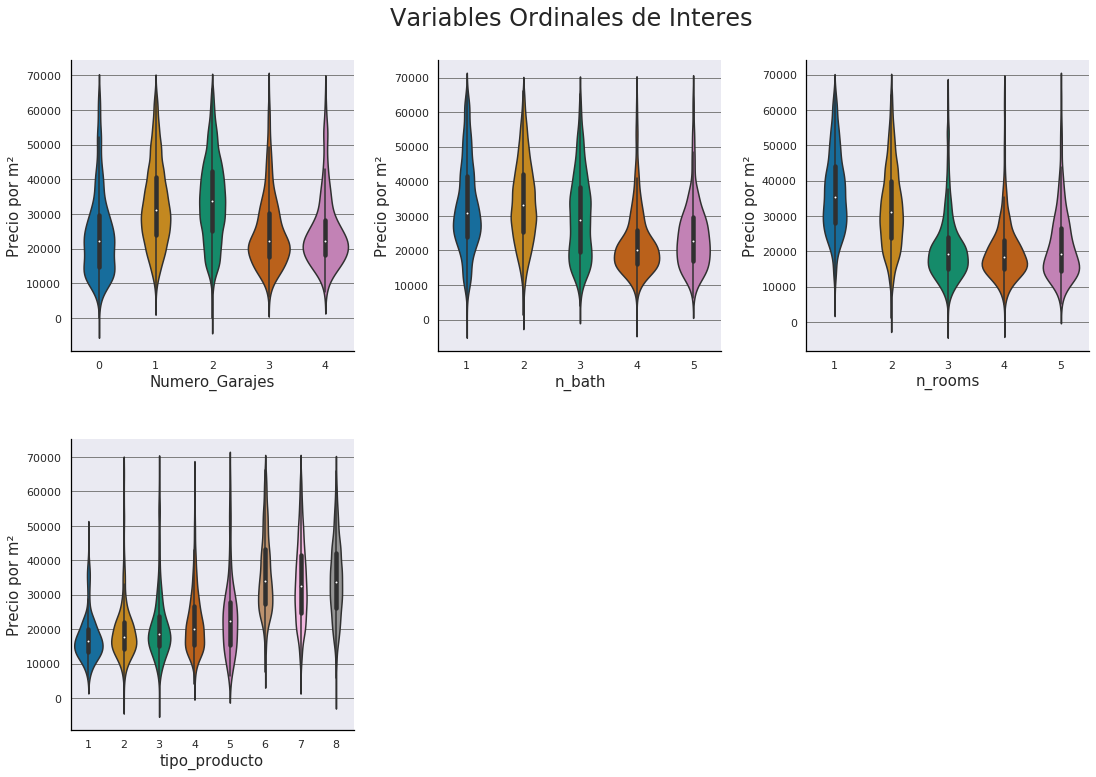

In [18]:
ord_interes=Ordinales.copy()
interes('Ordinales', ord_interes)

## Variables Numéricas

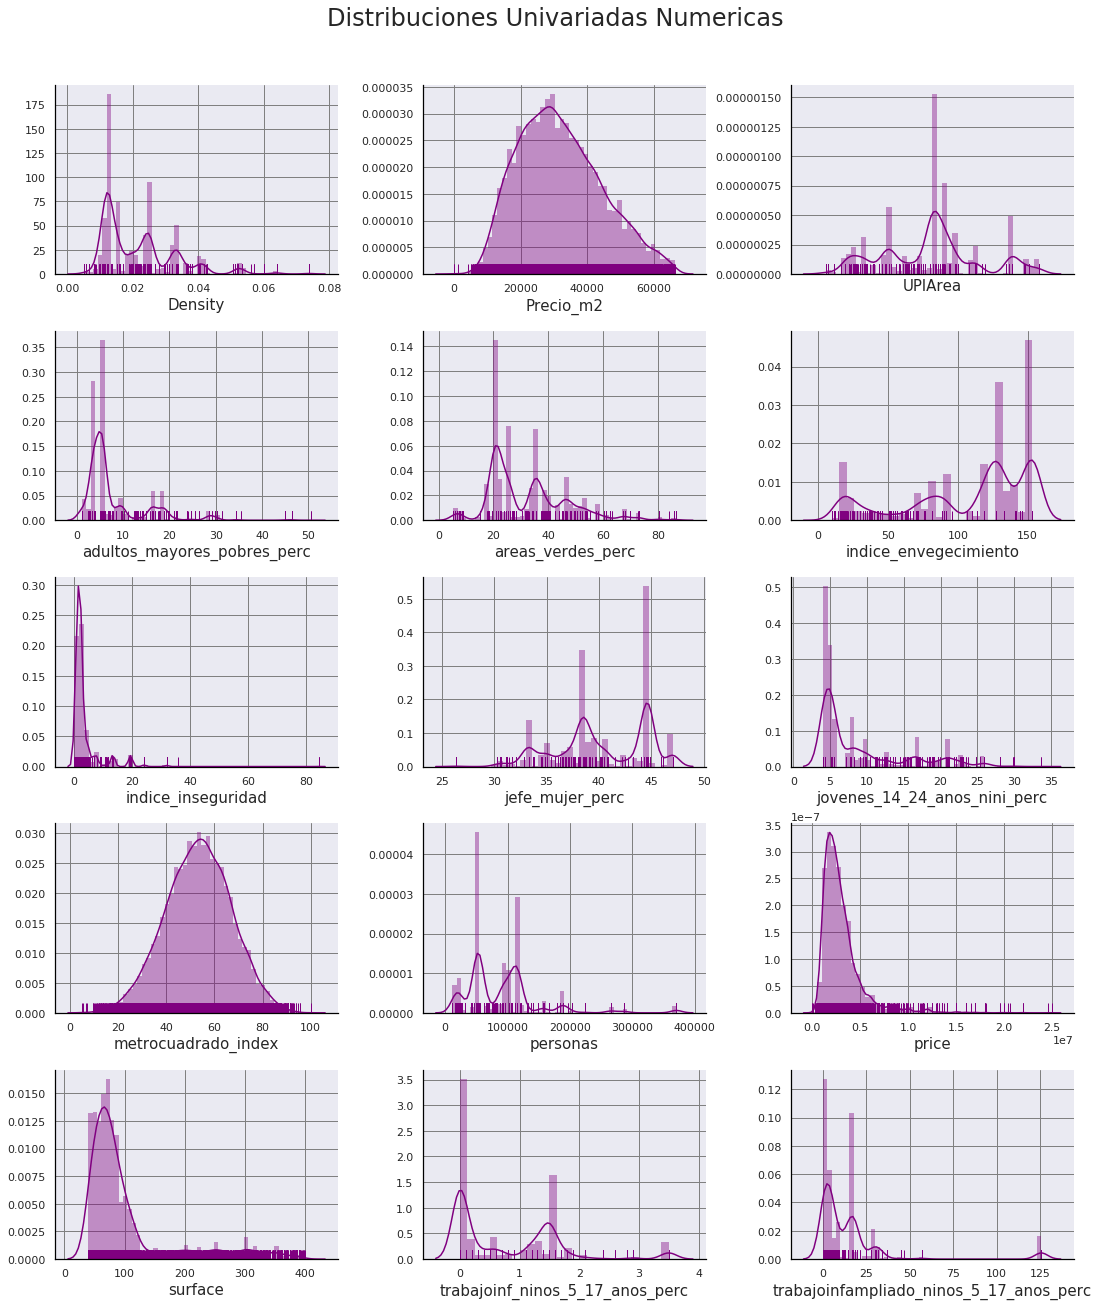

In [19]:
distribucion('Numericas', Numericas)

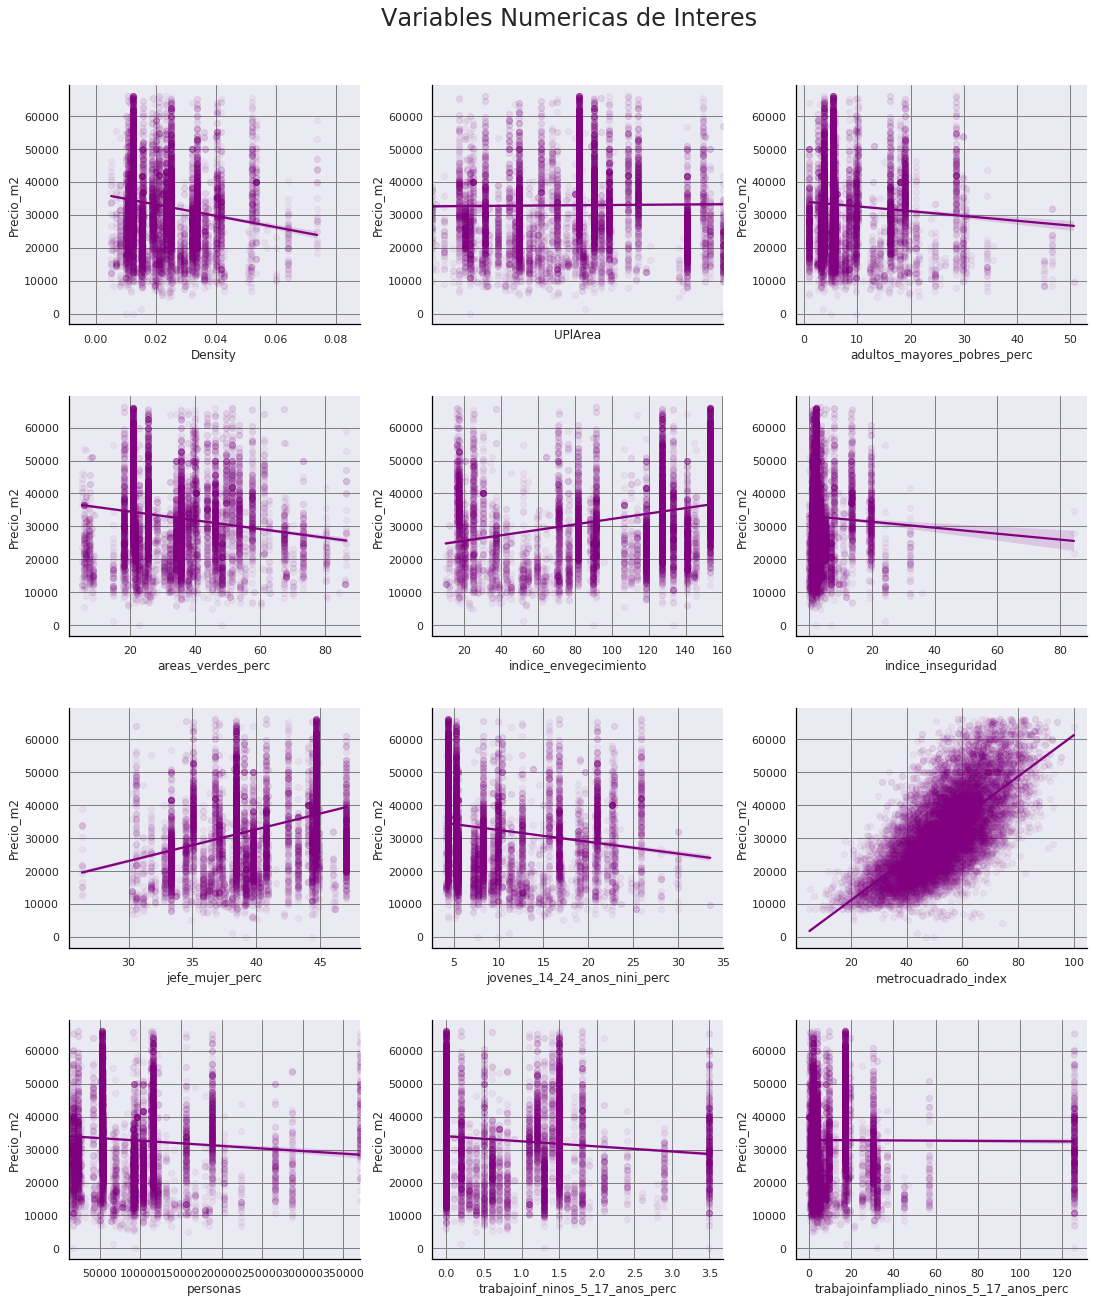

In [20]:
num_interes=Numericas.copy()
for d in ['price','surface', 'Precio_m2']:
    num_interes.remove(d)
interes('Numericas', num_interes)

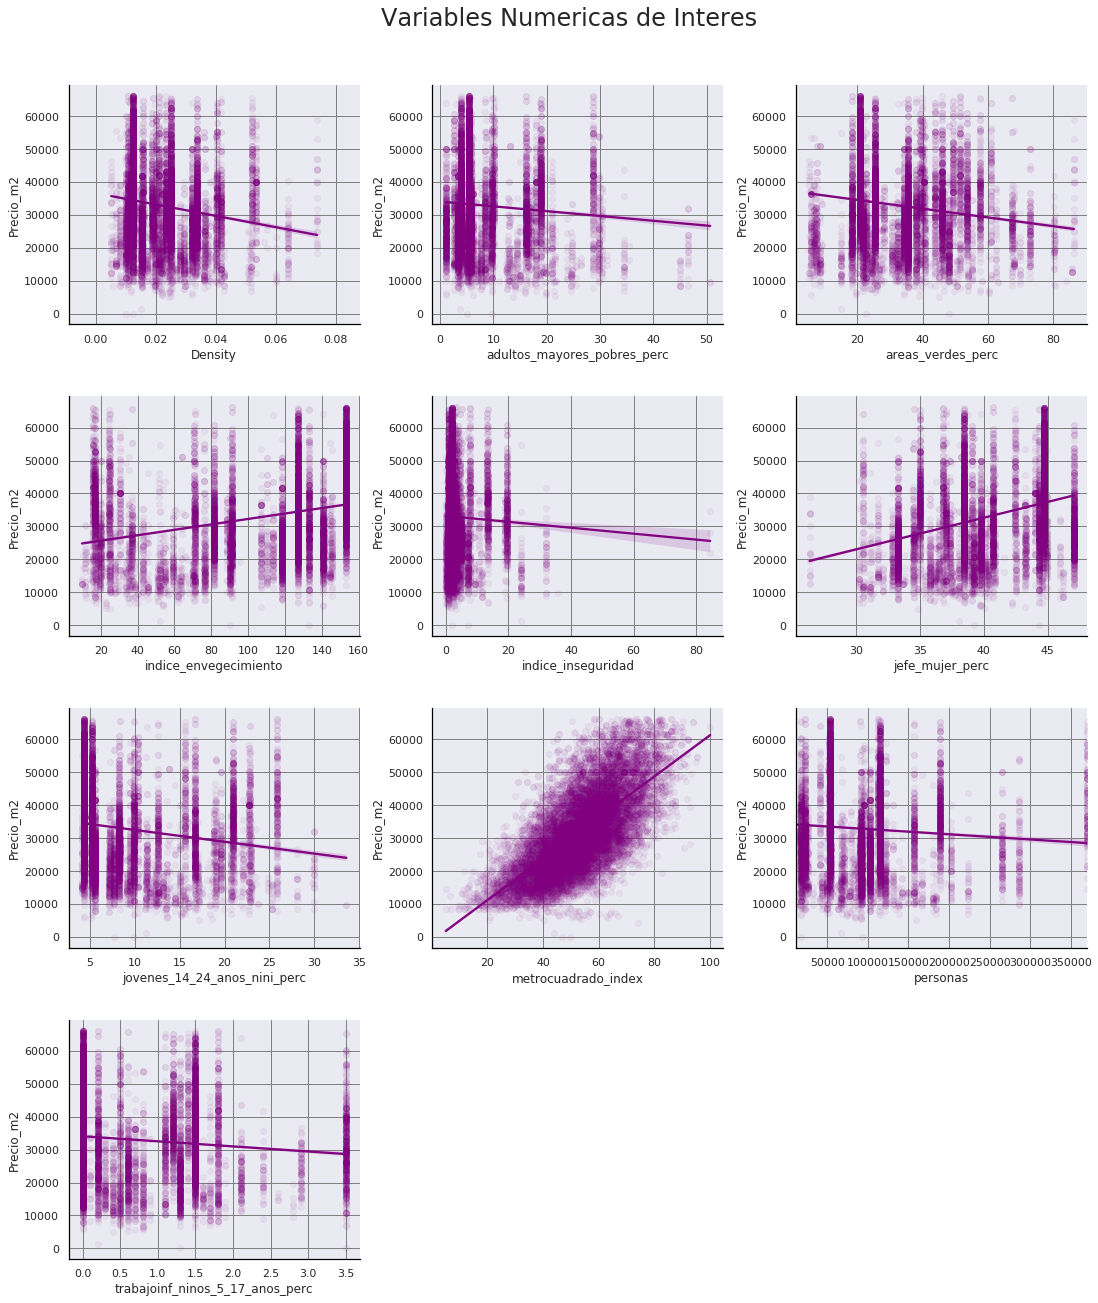

In [23]:
for d in ['trabajoinfampliado_ninos_5_17_anos_perc', 'UPlArea', ]:
    num_interes.remove(d)
interes('Numericas', num_interes)

3. Estudie la presencia de datos faltantes en la base de datos. Observe como se distribuyen estos y establezca un mecanismo de pérdida de información basándose en los patrones observables del conjunto de datos. Busque agrupaciones de columnas que muestren un comportamiento sistemático y plantee sus reflexiones.\
Respalde con visualizaciones y cuantifique estadísticamente los patrones observados.

In [21]:
import missingno as msno

In [22]:
df = pd.read_pickle('./data/data_perfilada.pkl')

In [23]:
df.replace('nan',np.nan, inplace = True)
df.isnull().sum().nlargest(15)

Numericas    Density                                    1635
             UPlArea                                    1635
             adultos_mayores_pobres_perc                1635
             areas_verdes_perc                          1635
             indice_envegecimiento                      1635
             indice_inseguridad                         1635
             jefe_mujer_perc                            1635
             jovenes_14_24_anos_nini_perc               1635
             personas                                   1635
             trabajoinf_ninos_5_17_anos_perc            1635
             trabajoinfampliado_ninos_5_17_anos_perc    1635
Categoricas  UPlCodigo                                  1635
             UPlNombre                                  1635
Numericas    Precio_m2                                     0
             metrocuadrado_index                           0
dtype: int64

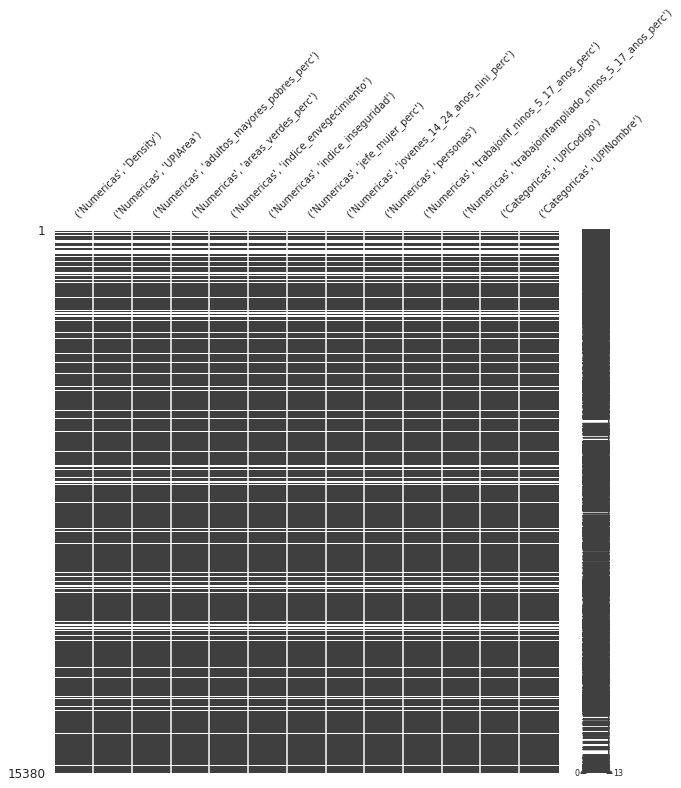

In [24]:
fig =msno.matrix(df[df.isnull().sum().nlargest(13).index],
                 sparkline=True, figsize=(10,10), fontsize=10)
fig_copy = fig.get_figure()
fig_copy.savefig('./fig/missing_dist.pdf',bbox_inches='tight')

## Little's MCAR test

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, QuantileTransformer
from sklearn.impute import SimpleImputer

In [25]:
df=pd.read_pickle('./data/data.pkl')

num_cols = ['metrocuadrado_index','trabajoinf_ninos_5_17_anos_perc', 'UPlArea', 'personas',
            'price', 'surface', 'trabajoinfampliado_ninos_5_17_anos_perc', 
            'jovenes_14_24_anos_nini_perc', 'indice_envegecimiento','jefe_mujer_perc', 
            'adultos_mayores_pobres_perc', 'indice_inseguridad', 'areas_verdes_perc', 'Density']

ordinal_cols = ['Numero_Garajes','n_bath','n_rooms','tipo_producto']
cat_cols = ['property_type', 'rent_type', 'Archivo', 'UPlNombre', 'UPlCodigo', 'location']

# Adquieren las categorias de cada variable
ordinal_cat = [['0', '1', '2', '3', '4', '4+'],
               ['1', '2', '3', '4', '5', '5+'],
               ['1', '2', '3', '4', '5', '5+'],
               [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]]

In [26]:
# Pipeline categorica
cat_pipe = Pipeline(
    steps=[('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')), 
           ('onehot',OneHotEncoder(sparse=False, handle_unknown='ignore'))])
# Pipeline Numerica
num_pipe = Pipeline(steps=[('quantile', QuantileTransformer())]) #Quita peso a outliers
# Pipeline Ordinal
ord_pipe = Pipeline(
    steps=[('imputer_ord', SimpleImputer(strategy='constant', fill_value='NA')),
           ('ordinal', OrdinalEncoder(categories = ordinal_cat))])

#Preprocesador Compuesto
prep = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols), 
                  ('cat', cat_pipe, cat_cols), 
                  ('ord', ord_pipe, ordinal_cols)])

In [27]:
X=df.drop([col for col in ['Precio_m2']], axis=1).copy()
y = df['Precio_m2'].copy()
X_prep = prep.fit_transform(X)

# Se obtienen las variables categoricas transformadas
post_cat = prep.named_transformers_['cat'][-1]
cat_cols_fit = post_cat.get_feature_names(cat_cols)
post_cols = list(num_cols)+list( cat_cols_fit) + list(ordinal_cols)

df_post = pd.DataFrame(data=X_prep, columns=post_cols)

In [35]:
from mcar import little_mcar
chi, d, p = little_mcar(df_post).values()
if p<0.001: print('Se rechaza H_0: No es MCAR p =', p)
else: print('No se puede rechazar H_0.')

Se rechaza H_0: No es MCAR p = 4.122483732826865e-06


## Iterative Imputer

Como no es MCAR, se asume que es MAR, luego se implementa un iterative imputer para rellenar los datos faltantes, ya que de esta forma se puede preservar mejor la varianza de los datos.

In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, QuantileTransformer

In [38]:
# Pipeline Numerica
num_pipe = Pipeline(steps=[('quantile', QuantileTransformer())]) #Quita peso a outliers

# Pipeline categorica
cat_pipe = Pipeline(
    steps=[('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')), 
           ('onehot',OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# Pipeline Ordinal
ord_pipe = Pipeline(
    steps=[('imputer_ord', SimpleImputer(strategy='constant', fill_value='NA')),
           ('ordinal', OrdinalEncoder(categories = ordinal_cat))])

#Preprocesador Compuesto
prep = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols), 
                  ('cat', cat_pipe, cat_cols), 
                  ('ord', ord_pipe, ordinal_cols)])

In [39]:
X=df.drop([col for col in ['Precio_m2']], axis=1).copy()
y = df['Precio_m2'].copy()
X_prep = prep.fit_transform(X)

# Se obtienen las variables categoricas transformadas
post_cat = prep.named_transformers_['cat'][-1]
cat_cols_fit = post_cat.get_feature_names(cat_cols)
post_cols = list(num_cols)+list( cat_cols_fit) + list(ordinal_cols)

#Dataset a imputar
df_post = pd.DataFrame(data=X_prep, columns=post_cols)

In [40]:
rf = RandomForestRegressor(random_state=0, n_estimators=5, n_jobs=4)

imputer_RF = IterativeImputer(estimator=rf,
                              skip_complete=True,
                              verbose=1,
                              random_state=1)

In [41]:
A=imputer_RF.fit_transform(df_post)

[IterativeImputer] Completing matrix with shape (15394, 776)
[IterativeImputer] Change: 2.2469013936112794, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.8425943708973489, scaled tolerance: 0.007 
[IterativeImputer] Change: 1.232558791731095, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.7640903232626366, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.9141153482876625, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.9317329659052802, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.9317329659052802, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.9317329659052803, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.9317329659052801, scaled tolerance: 0.007 
[IterativeImputer] Change: 0.9317329659052801, scaled tolerance: 0.007 


In [42]:
df_A=pd.DataFrame(A, index=df_post.index, columns=df_post.columns)

In [43]:
df_A=df_A[num_cols]
df_A[cat_cols]=df[cat_cols]
df_A[ordinal_cols]=df[ordinal_cols]

#UPlCodigo y UPlNombre no se pueden llenar, luego se agrega categoria nan
df_A.replace(np.nan, 'Otro', inplace=True)

In [44]:
qt=QuantileTransformer()
df_A['Precio_m2']=qt.fit_transform(df[['Precio_m2']])
num_cols.append('Precio_m2')
num_cols.sort()
cat_cols.sort()
ordinal_cols.sort()

'''Se eliminan algunas observaciones para poder transformar'''
df_A=df_A[df.Numero_Garajes!='4+'] #9 obs
df_A=df_A[df.n_rooms!='5+'] #8 obs
df_A=df_A[df.n_bath!='5+']  #7 obs

df_A = df_A.astype({col:'str' for col in cat_cols})
df_A = df_A.astype({col:'int' for col in ordinal_cols})
df_A = df_A.astype({col:'float64' for col in num_cols})

mapping = [('Numericas', col) for col in num_cols]
mapping.extend([('Categoricas', col) for col in cat_cols])
mapping.extend([('Ordinales', col) for col in ordinal_cols])

df_A = df_A.reindex(columns=num_cols + cat_cols + ordinal_cols)
df_A.columns = pd.MultiIndex.from_tuples(mapping)

df_A.to_pickle('./data/data_RF.pkl')

4. Recategoríce la variable código de UPZ de forma que quede distribuida entre 3 a 5 grupos, evalúe la significancia estadística de esta nueva agrupación en comparación a la variable de respuesta. Comente sus resultados e interprételos.\
__Hint:__ Puede probar con técnicas de clustering (como k-means) sobre una agrupación de UPZ y validar estadísticamente si las nuevas categorías afectan la variable de respuesta.

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import f_oneway

In [46]:
'''Se leen datos llenados y transformados'''
df=pd.read_pickle('./data/data_RF.pkl')

'''Creo DataFrame auxiliar con hot encoding'''
encoding = pd.get_dummies(df['Categoricas']['UPlCodigo'])
encoding['Precio_m2']=df['Numericas']['Precio_m2']
encoding['UPlCodigo']=df['Categoricas']['UPlCodigo']

Xdata=pd.DataFrame(encoding.iloc[:,:-2], 
                   index=encoding.iloc[:,:-2].index, 
                   columns=encoding.iloc[:,:-2].columns)

In [48]:
def upzcluster(n, encoding=encoding, data=Xdata):
    '''
    Funcion para comparar la calidad de clusterizacion:
        n: el numero de clusters deseado
        encoding, data: las variables auxiliares definidas anteriormente
    
    Imprime en pantalla puntajes de clusterizacion y test para verificar 
    cuanto afecta en la variable de respuesta (Precio_m2). 
    Finalmente plotea el grafo de violin para el cluster para constrastar
    con el test estadistico.
    '''
    kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
    labels=kmeans.labels_
    aux=encoding.copy()
    aux['label']=labels

    fig, ax = plt.subplots(2,1,figsize=(8,8))
    fig.suptitle('Analisis N° Cluster = '+str(n))

    sns.violinplot(x='label',y='Precio_m2',data=aux,kind='violin',ax=ax[0])

    sns.countplot(aux['label'], ax=ax[1])

    ax[0].set_xlabel('UPZ cluster')
    ax[1].set_xlabel('UPZ Cluster')

    ax[0].set_ylabel('Precio por m²')
    ax[0].set_title('Violin plot UPZ vs Price_m²')
    ax[1].set_title('Frecuencias UPZ Cluster')

    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)
    fig.show()
    fig.savefig('./fig/'+str(n)+'_clusters.pdf')
    
    aux=aux.iloc[:,-3:]
    clusters=aux.copy()    
    aux.drop('UPlCodigo', axis=1, inplace=True)
    group_to_test=[]
    for m in np.unique(aux.label):
        group_to_test.append(aux[aux.label==m][['Precio_m2']])
    F,p = f_oneway(*group_to_test)
    alpha = 0.05
    
    print('N =', n)
    print('silhouette:',silhouette_score(data,labels))
    print('calinski harabasz:',calinski_harabasz_score(data, labels))
    print('Estadistico F:',F)
    print('p valor :', p)
    if p <= alpha: print('N =',n,'apaña')
    print('='*80)
    return clusters

N = 3
silhouette: 0.35571292340073624
calinski harabasz: 3266.082588924858
Estadistico F: [2347.26924375]
p valor : [0.]
N = 3 apaña
N = 4
silhouette: 0.4494788025849838
calinski harabasz: 3421.1869423871653
Estadistico F: [1832.95180728]
p valor : [0.]
N = 4 apaña
N = 5
silhouette: 0.511628046880458
calinski harabasz: 3381.488571571023
Estadistico F: [1451.14093068]
p valor : [0.]
N = 5 apaña


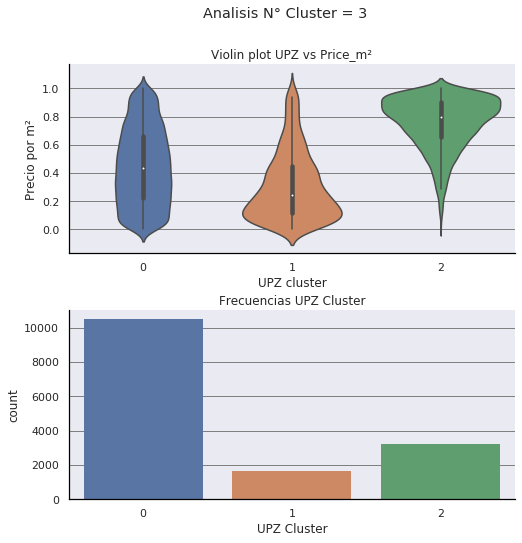

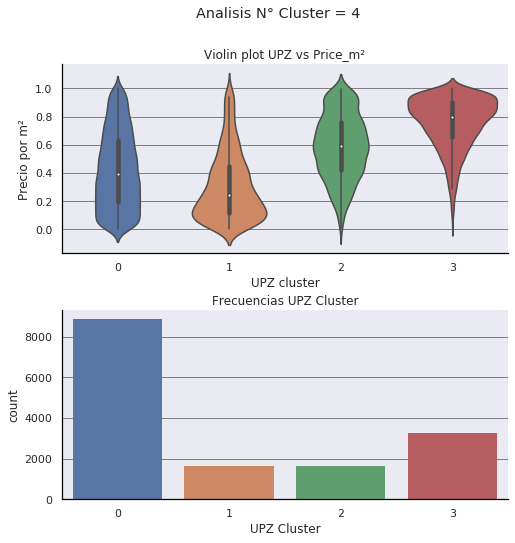

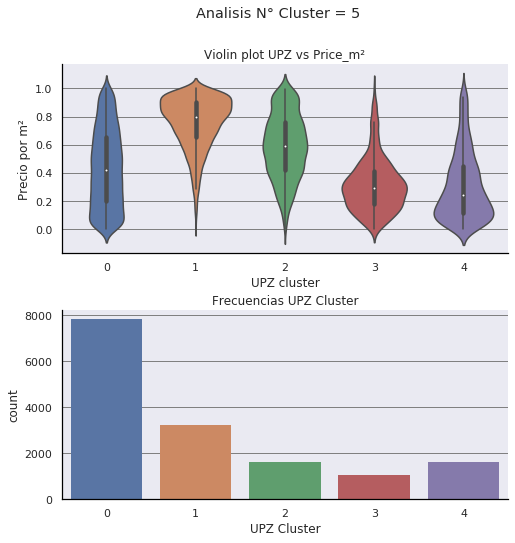

In [49]:
Groups=[]
for m in [3,4,5]:
    Groups.append(upzcluster(m))

In [50]:
#Se decide agruparlos de a 3:
cluster=Groups[0].iloc[:,-1:]
df[('Ordinales','UPlCluster')]=cluster.label
df.drop(('Categoricas','UPlCodigo'), axis=1, inplace=True)
df.sort_index(level=0, axis=1, inplace=True)
df.to_pickle('./data/data_cluster.pkl')

5. Cuantifique estadísticamente las relaciones entre una selección de al menos 10 variables de interés y la columna de respuesta, examine también las relaciones entre las variables de su selección. Utilice las herramientas de análisis estadístico que considere pertinentes, comente brevemente sus hallazgos.

## Análisis Datos transformados y llenados

In [51]:
def indexer(cols, t_c = df.columns):
    '''Genera columnas multinivel a partir de nombres de columna planos.'''
    
    set_to_tuple = set(*[cols])

    tuples = [
        i for i in t_c if set_to_tuple.intersection(set(i))
    ]
    
    return tuples

In [58]:
'''
Se cargan datos transformados por QuantileTransformer, llenados segun RF e IterativeImputer.
También se agruparon los codigos en UPlClusters segun los resultados de la parte 4 (3 grupos)
Cluster 1: Obs sin codigo UPZ
Cluster 2: Obs con codigo UPZ97
Cluster 0: Todos los demas
'''
df=pd.read_pickle('./data/data_cluster.pkl')
col_interes = ['Archivo', 'property_type', 
           
           'Numero_Garajes', 'n_bath', 'n_rooms', 'tipo_producto',
           
           'Density', 'areas_verdes_perc', 'indice_envegecimiento',
           'jefe_mujer_perc', 'metrocuadrado_index', 'Precio_m2',
           
           'adultos_mayores_pobres_perc', 'indice_inseguridad',
           'jovenes_14_24_anos_nini_perc', 'personas',
           'trabajoinf_ninos_5_17_anos_perc']
idxs = indexer(col_interes)
df=df[idxs]
df.head()

Categoricas               Numericas                                        \
      Archivo property_type   Density Precio_m2 adultos_mayores_pobres_perc   
0         all          Casa  0.809796  0.718877                    0.698899   
1         all          Casa  0.801874  0.004004                    0.679179   
2         all          Casa  0.484985  0.099600                    0.630631   
3         all          Casa  0.809796  0.117537                    0.698899   
4         all          Casa  0.809796  0.057558                    0.698899   

                                                                              \
  areas_verdes_perc indice_envegecimiento indice_inseguridad jefe_mujer_perc   
0          0.708308              0.168306           0.065978        0.328279   
1          0.669169              0.252352           0.224737        0.309710   
2          0.532032              0.170671           0.758258        0.181682   
3          0.708308              0.168306           0.065978        0.328279   
4          0.708308              0.168306           0.065978        0.328279   

                                                              \
  jovenes_14_24_anos_nini_perc metrocuadrado_index  personas   
0                     0.783283            0.606106  0.481281   
1                     0.725501            0.001205  0.496096   
2                     0.687187            0.324324  0.133133   
3                     0.783283            0.479479  0.481281   
4                     0.783283            0.078078  0.481281   

                                       Ordinales                               
  trabajoinf_ninos_5_17_anos_perc Numero_Garajes n_bath n_rooms tipo_producto  
0                        0.656590              1      2       3             1  
1                        0.525726              0      1       3             1  
2                        0.912913              1      3       4             1  
3                        0.656590              1      2       4             1  
4                        0.656590              1      2       4             1

### Variables Numéricas

In [59]:
corrmat = df.Numericas.corr()
corrmat[['Precio_m2']].abs().nlargest(10, ['Precio_m2'])

Precio_m2
Precio_m2                         1.000000
metrocuadrado_index               0.698321
indice_envegecimiento             0.436060
jovenes_14_24_anos_nini_perc      0.380514
jefe_mujer_perc                   0.353927
areas_verdes_perc                 0.243138
Density                           0.212634
trabajoinf_ninos_5_17_anos_perc   0.194621
indice_inseguridad                0.172233
personas                          0.117373

Se borran las 3 menos correlacionadas

In [60]:
df.drop([('Numericas', col) for col in ['indice_inseguridad', 'personas', 'adultos_mayores_pobres_perc']],
        axis=1, inplace=True)

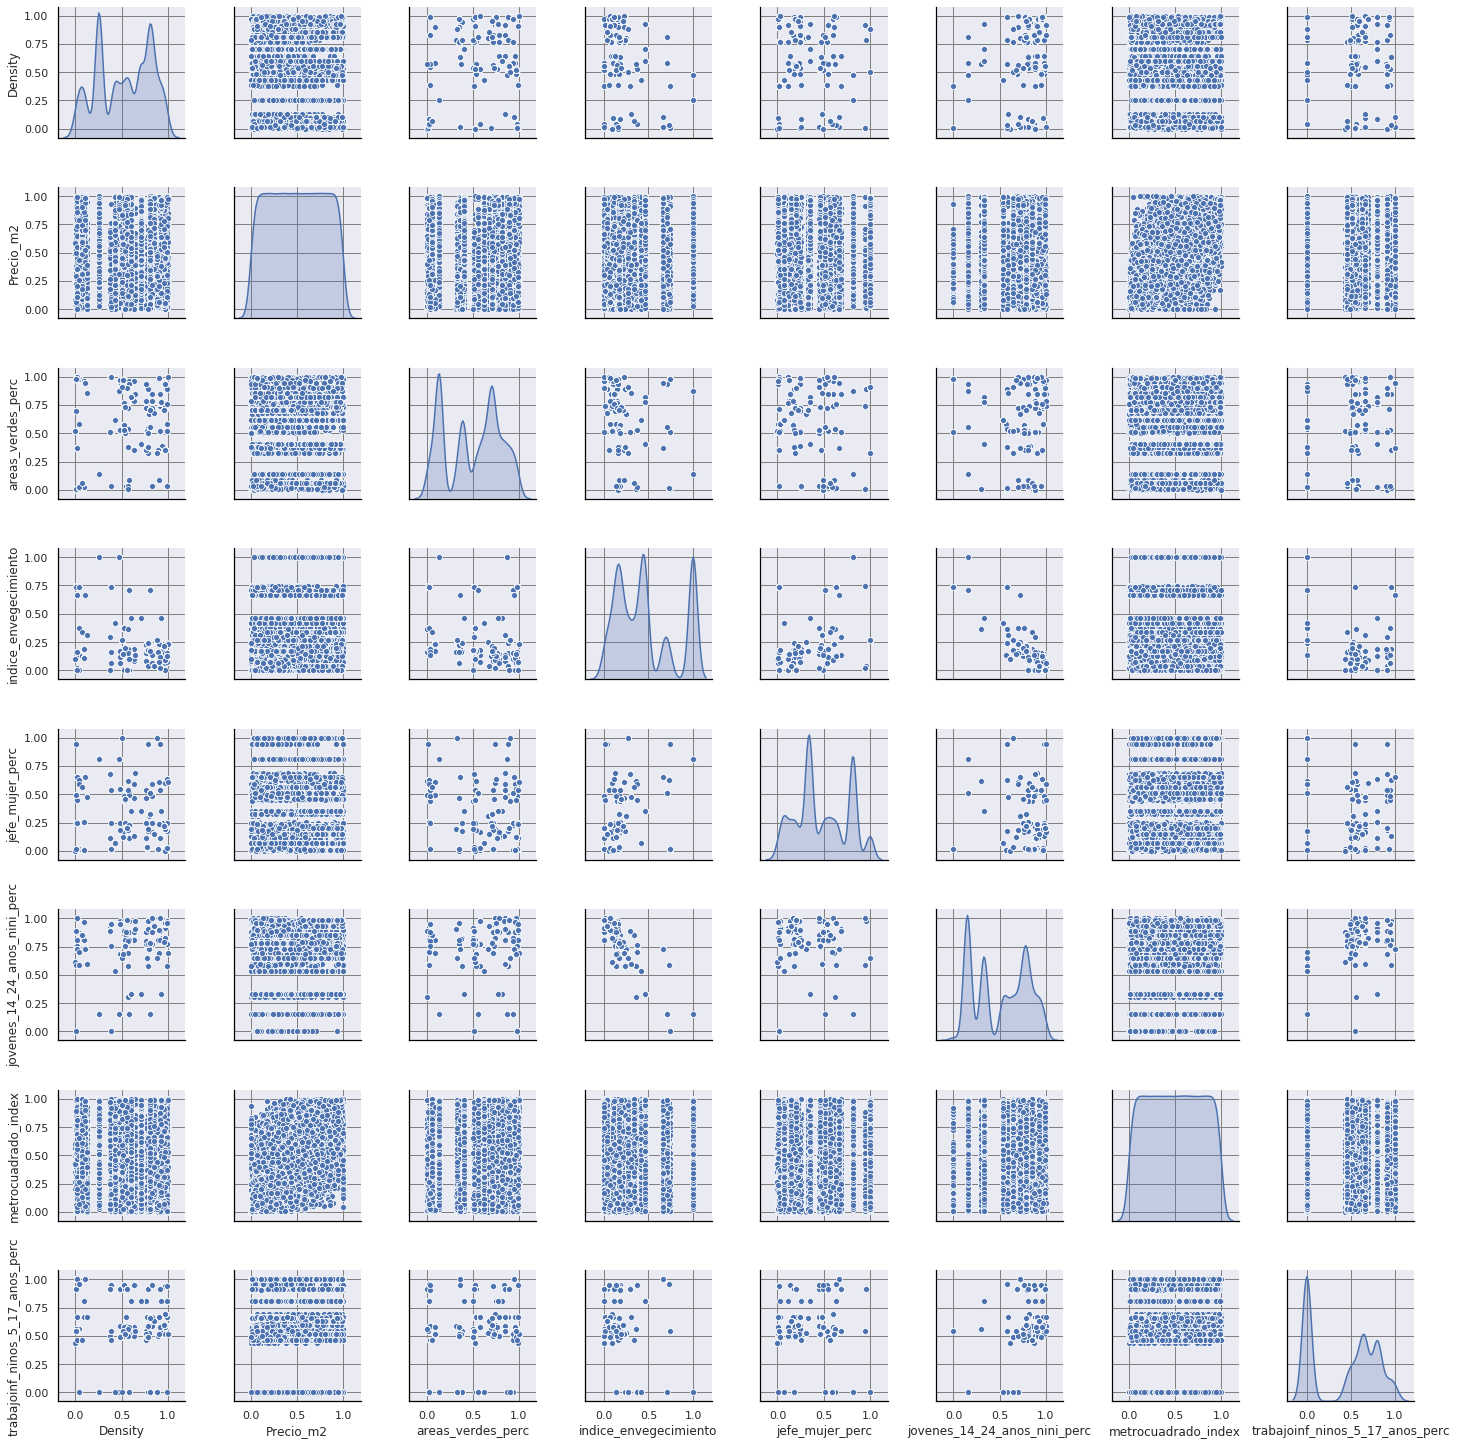

In [61]:
fig = plt.figure(figsize=(17,17))
fig.suptitle('Pairplot de las 7 Numéricas más correlacionadas con la variable de respuesta')
data = df.Numericas.copy()
sns.pairplot(data = data, diag_kind='kde')
fig.savefig('./fig/pairplot_full.pdf')

Se observan relaciones entre las variables ``indice_envegecimiento``, ``jefe_mujer_perc``, ``jovenes_14_24_anos_nini_perc`` y ``areas_verdes_perc``

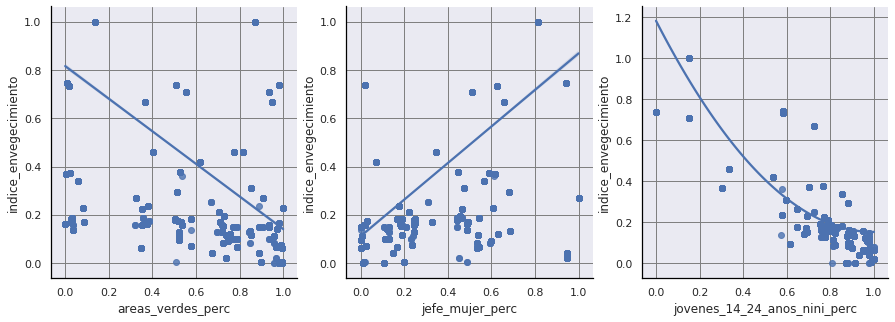

In [62]:
fig , ax = plt.subplots(1,3, figsize=(15,5))
sns.regplot(y='indice_envegecimiento', x='areas_verdes_perc', data=df.Numericas, order=1, ax=ax[0])
sns.regplot(y='indice_envegecimiento', x='jefe_mujer_perc', data=df.Numericas, order=1, ax=ax[1])
sns.regplot(y='indice_envegecimiento', x='jovenes_14_24_anos_nini_perc', data=df.Numericas, order=2, ax=ax[2])
fig.show()

Para no tener problemas con las hipotesis del modelo lineal se tomara la mas correlacionada con la variable de respuesta, en este caso ``indice_envegecimiento``

In [63]:
df.drop([('Numericas', col) for col in ['areas_verdes_perc', 'jefe_mujer_perc', 'jovenes_14_24_anos_nini_perc']],
        axis=1, inplace=True)

Text(119.59374999999999, 0.5, '')

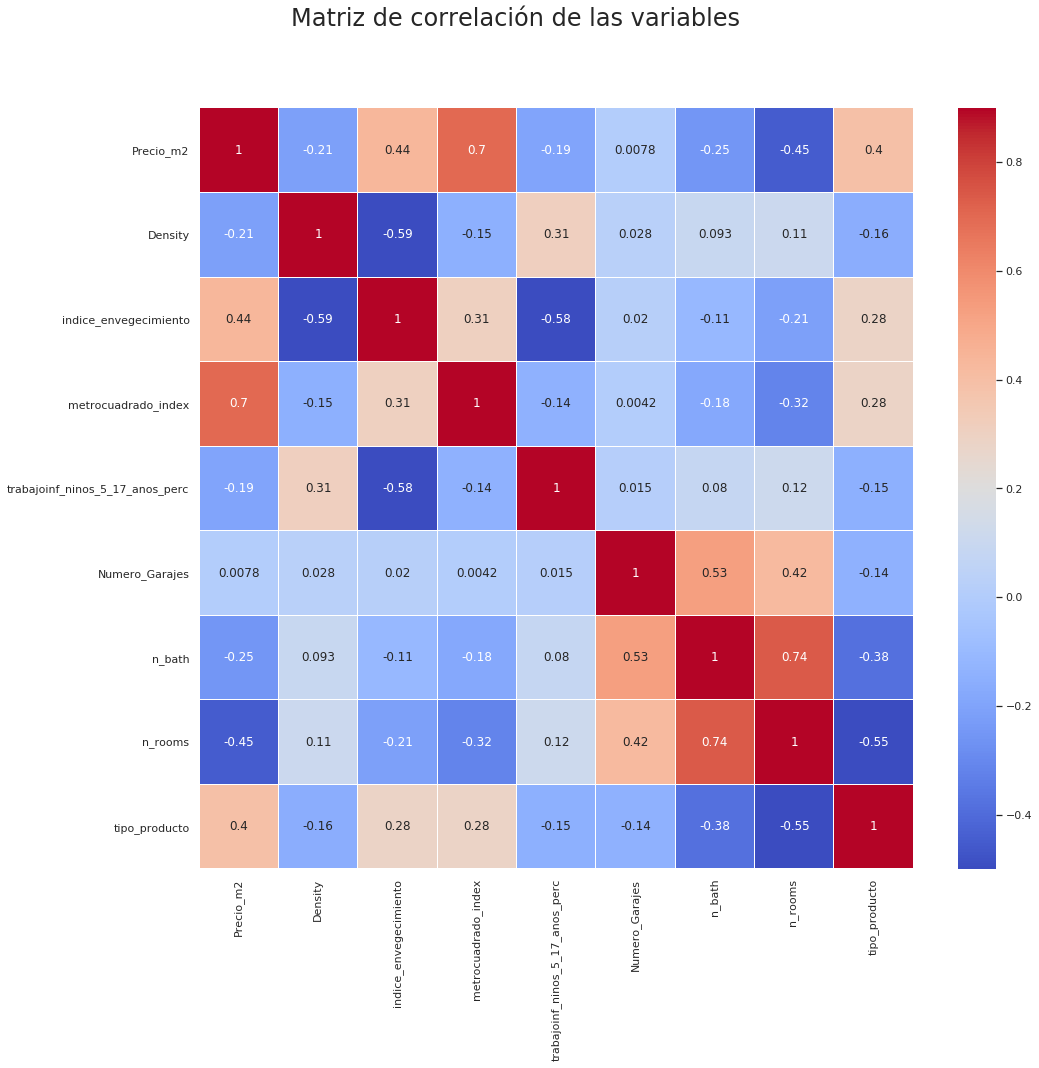

In [66]:
corrmat = df.corr()
col = indexer(['Precio_m2'], df.columns)

unsorted = list(corrmat.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corrmat.reindex(index = sortd, columns = sortd)
etiquetas=list(corrmat.columns.droplevel(0).values)

fig, ax = plt.subplots(figsize=[16, 14])
fig.suptitle('Matriz de correlación de las variables',fontsize=24, x=0.4)
ax=sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01, cmap='coolwarm', annot=True, fmt='.2g',
              yticklabels=etiquetas, xticklabels=etiquetas)
ax.set_xlabel('')
ax.set_ylabel('')
#fig.savefig('./fig/matriz_corr2.pdf', bbox_inches='tight')

### Variables Ordinales

De la matriz anterior se ve una fuerte correlacion entre las variables ``n_bath`` y ``n_rooms``. También se observa menos fuerte entre ``Numero_Garajes`` y las dos anteriores. Por último se ve una relacion entre ``tipo_producto`` y ``n_bath``, ``n_rooms``

In [68]:
from scipy.stats import chi2_contingency

In [98]:
def compara_vars(ord1, ord2, tipo='Ordinales', df=df):
    to_compare =[ord1,ord2]
    data_ord = df[tipo]
    kwargs = {'index': data_ord[to_compare[0]], 'columns': data_ord[to_compare[1]]}
    tabla = pd.crosstab(**kwargs, margins=False)
    chi2, p, dof, ex =chi2_contingency(tabla)
    
    expected_freq = pd.DataFrame(ex, 
                                 index=np.unique(df[tipo][ord1]), 
                                 columns=np.unique(df[tipo][ord2]))
    expected_freq.index.name = ord1
    expected_freq.columns.name = ord2
    if p<=0.01:
        print('Existe una dependencia entre las variables',ord1, 'y', ord2, ', p =', p)
    else:
        print('No se puede rechazar H_0. No hay dependencia')
    
    return expected_freq

In [92]:
l1=['n_bath','Numero_Garajes','Numero_Garajes','tipo_producto','tipo_producto']
l2=['n_rooms', 'n_rooms','n_bath','n_bath', 'n_rooms']
for ord1, ord2 in zip(l1,l2):
    print(ord1,'vs',ord2)
    print('='*80)
    display(compara_ord(ord1,ord2))
    print('='*80)

n_bath vs n_rooms
Existe una dependencia entre las variables n_bath y n_rooms , p = 0.0


n_rooms            1            2           3           4           5
n_bath                                                               
1        1179.875163  1199.134460  241.811183  215.548505  155.630689
2        2989.910923  3038.715735  612.771521  546.219506  394.382315
3        1122.301040  1140.620546  230.011573  205.030429  148.036411
4         463.353381   470.916775   94.962614   84.648895   61.118336
5         309.559493   314.612484   63.443108   56.552666   40.832250

Numero_Garajes vs n_rooms
Existe una dependencia entre las variables Numero_Garajes y n_rooms , p = 0.0


n_rooms                   1            2           3           4           5
Numero_Garajes                                                              
0                566.276983   575.520416  116.056437  103.451756   74.694408
1               2910.253576  2957.758127  596.446034  531.667100  383.875163
2               2085.681730  2119.726658  427.452991  381.028088  275.110533
3                278.406372   282.950845   57.058388   50.861378   36.723017
4                224.381339   228.043953   45.986151   40.991678   29.596879

Numero_Garajes vs n_bath
Existe una dependencia entre las variables Numero_Garajes y n_bath , p = 0.0


n_bath                    1            2            3           4           5
Numero_Garajes                                                               
0                279.357087   707.916255   265.725358  109.707412   73.293888
1               1435.693108  3638.176853  1365.635891  563.816645  376.677503
2               1028.913394  2607.360078   978.705722  404.068596  269.952211
3                137.344083   348.042393   130.642133   53.936931   36.034460
4                110.692328   280.504421   105.290897   43.470416   29.041938

tipo_producto vs n_bath
Existe una dependencia entre las variables tipo_producto y n_bath , p = 0.0


n_bath                  1            2           3           4           5
tipo_producto                                                             
1               57.194278   144.935501   54.403381   22.460988   15.005852
2              109.330559   277.053576  103.995579   42.935631   28.684655
3              123.920936   314.026918  117.873992   48.665475   32.512679
4              248.620026   630.025748  236.488166   97.636541   65.229519
5              119.252016   302.195449  113.432900   46.831925   31.287711
6              723.099090  1832.398830  687.814174  283.971066  189.716840
7              868.030169  2199.667360  825.673082  340.887516  227.741873
8              742.552926  1881.696619  706.318726  291.610858  194.820871

tipo_producto vs n_rooms
Existe una dependencia entre las variables tipo_producto y n_rooms , p = 0.0


n_rooms                  1            2           3           4           5
tipo_producto                                                              
1               115.936931   117.829389   23.760858   21.180234   15.292588
2               221.620936   225.238492   45.420416   40.487386   29.232770
3               251.196684   255.297009   51.481860   45.890507   33.133940
4               503.970741   512.197139  103.286996   92.069181   66.475943
5               241.732445   245.678283   49.542198   44.161508   31.885566
6              1465.774057  1489.700130  300.405137  267.778674  193.342003
7              1759.559818  1788.281404  360.615475  321.449675  232.093628
8              1505.208388  1529.778153  308.487061  274.982835  198.543563

In [126]:
for col in ['n_bath', 'n_rooms', 'tipo_producto', 'Numero_Garajes']:
    group_to_test=[]
    for m in np.unique(df.Ordinales[col].values):
        group_to_test.append(df.Numericas[df.Ordinales[col]==m][['Precio_m2']])
    F,p = f_oneway(*group_to_test)
    alpha = 0.05
    if p<alpha: 
        print(col)
        print('p =',p[0])
        print('F =', F[0])

n_bath
p = 2.9824758967430443e-221
F = 266.95528920967973
n_rooms
p = 0.0
F = 792.6495122590258
tipo_producto
p = 0.0
F = 428.90640455721234
Numero_Garajes
p = 8.471629306674536e-189
F = 226.79782222943496


### Variables categóricas

In [99]:
compara_vars('Archivo', 'property_type', 'Categoricas')

Existe una dependencia entre las variables Archivo y property_type , p = 7.788396997266172e-66


property_type  Apartamento        Casa
Archivo                               
all            10563.96775  2980.03225
furnished       1432.03225   403.96775

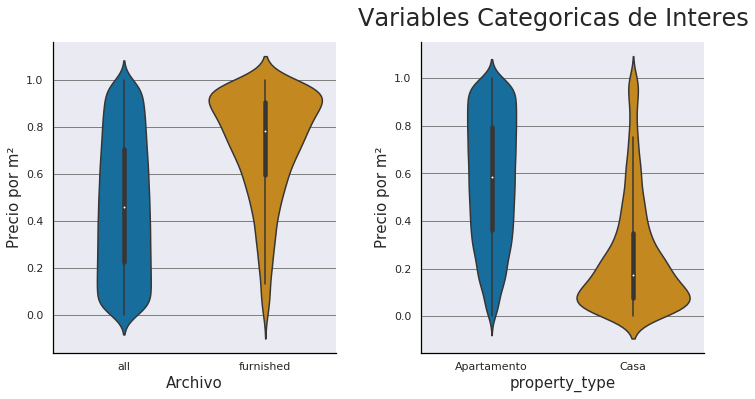

In [106]:
interes('Categoricas', ['Archivo', 'property_type'])

In [114]:
for col in ['Archivo', 'property_type']:
    group_to_test=[]
    for m in np.unique(df.Categoricas[col].values):
        group_to_test.append(df.Numericas[df.Categoricas[col]==m][['Precio_m2']])
    F,p = f_oneway(*group_to_test)
    alpha = 0.05
    if p<alpha: 
        print(col)
        print('p =',p[0])
        print('F =', F[0])

Archivo
p = 1.1189710685281421e-282
F = 1346.5855676985268
property_type
p = 0.0
F = 4082.15226086552


Es mejor ``property_type`` para explicar la variable ``Precio_m2``

## Analisis datos originales

Para ver si la transformación aplicada en los datos por ``QuantileTransformer`` no afectaron drasticamente los resultados anteriores, se procederá a analizar las mismas variables en el DataSet original, observaciones con valores anomalos en ``Precio_m2``

In [115]:
'''
Se cargan datos originales y no se consideran los NaNs
'''
df=pd.read_pickle('./data/data_perfilada.pkl')
col_interes = ['Archivo', 'property_type', 
           
           'Numero_Garajes', 'n_bath', 'n_rooms', 'tipo_producto',
           
           'Density', 'areas_verdes_perc', 'indice_envegecimiento',
           'jefe_mujer_perc', 'metrocuadrado_index', 'Precio_m2',
           
           'adultos_mayores_pobres_perc', 'indice_inseguridad',
           'jovenes_14_24_anos_nini_perc', 'personas',
           'trabajoinf_ninos_5_17_anos_perc']
idxs = indexer(col_interes)
df=df[idxs]
df.dropna(inplace=True)
df.head()

Categoricas               Numericas                \
       Archivo property_type   Density     Precio_m2   
2          all          Casa  0.017215  16250.000000   
6          all          Casa  0.023366  30000.000000   
8          all          Casa  0.021287  13888.888889   
9          all          Casa  0.029471  40000.000000   
11         all          Casa  0.005213  16666.666667   

                                                                        \
   adultos_mayores_pobres_perc areas_verdes_perc indice_envegecimiento   
2                     5.420442         32.395663                  54.7   
6                     3.840225         45.988424                 127.3   
8                     9.439051         38.278090                  42.7   
9                     7.638133         24.549297                  76.6   
11                    6.688596         32.151794                  24.7   

                                                                    \
   indice_inseguridad jefe_mujer_perc jovenes_14_24_anos_nini_perc   
2            3.166227       36.279630                          9.1   
6            2.505219       38.443910                          5.2   
8            2.527076       36.465059                          9.4   
9            1.158301       35.811188                          7.1   
11          11.157025       26.367889                          7.9   

                                                                  \
   metrocuadrado_index  personas trabajoinf_ninos_5_17_anos_perc   
2                 47.1   50037.0                             1.8   
6                 55.9  115124.0                             1.5   
8                 39.6   69961.0                             0.4   
9                 65.8   90943.0                             0.0   
11                28.7   24897.0                             0.1   

        Ordinales                               
   Numero_Garajes n_bath n_rooms tipo_producto  
2               1      3       4             1  
6               1      2       2             1  
8               1      2       4             1  
9               0      2       4             1  
11              1      2       3             1

In [116]:
'''No considero outliers de algunas columnas'''
for col in ['Precio_m2']:
    q = df.Numericas[col].quantile(0.99)
    df=df[df.Numericas[col] < q]

In [119]:
corrmat = df.Numericas.corr()
corrmat[['Precio_m2']].abs().nlargest(12, ['Precio_m2'])

Precio_m2
Precio_m2                         1.000000
metrocuadrado_index               0.691908
jefe_mujer_perc                   0.334157
indice_envegecimiento             0.293994
jovenes_14_24_anos_nini_perc      0.173281
Density                           0.151438
areas_verdes_perc                 0.141541
trabajoinf_ninos_5_17_anos_perc   0.109571
personas                          0.081484
adultos_mayores_pobres_perc       0.078752
indice_inseguridad                0.020453

Borramos las 3 peores. Se confirman las que habiamos determinados de interes y se descartan 3 numericas que presentaban duda en la parte 2

In [120]:
df.drop([('Numericas', col) for col in ['personas','adultos_mayores_pobres_perc', 'indice_inseguridad']],
        axis=1, inplace=True)

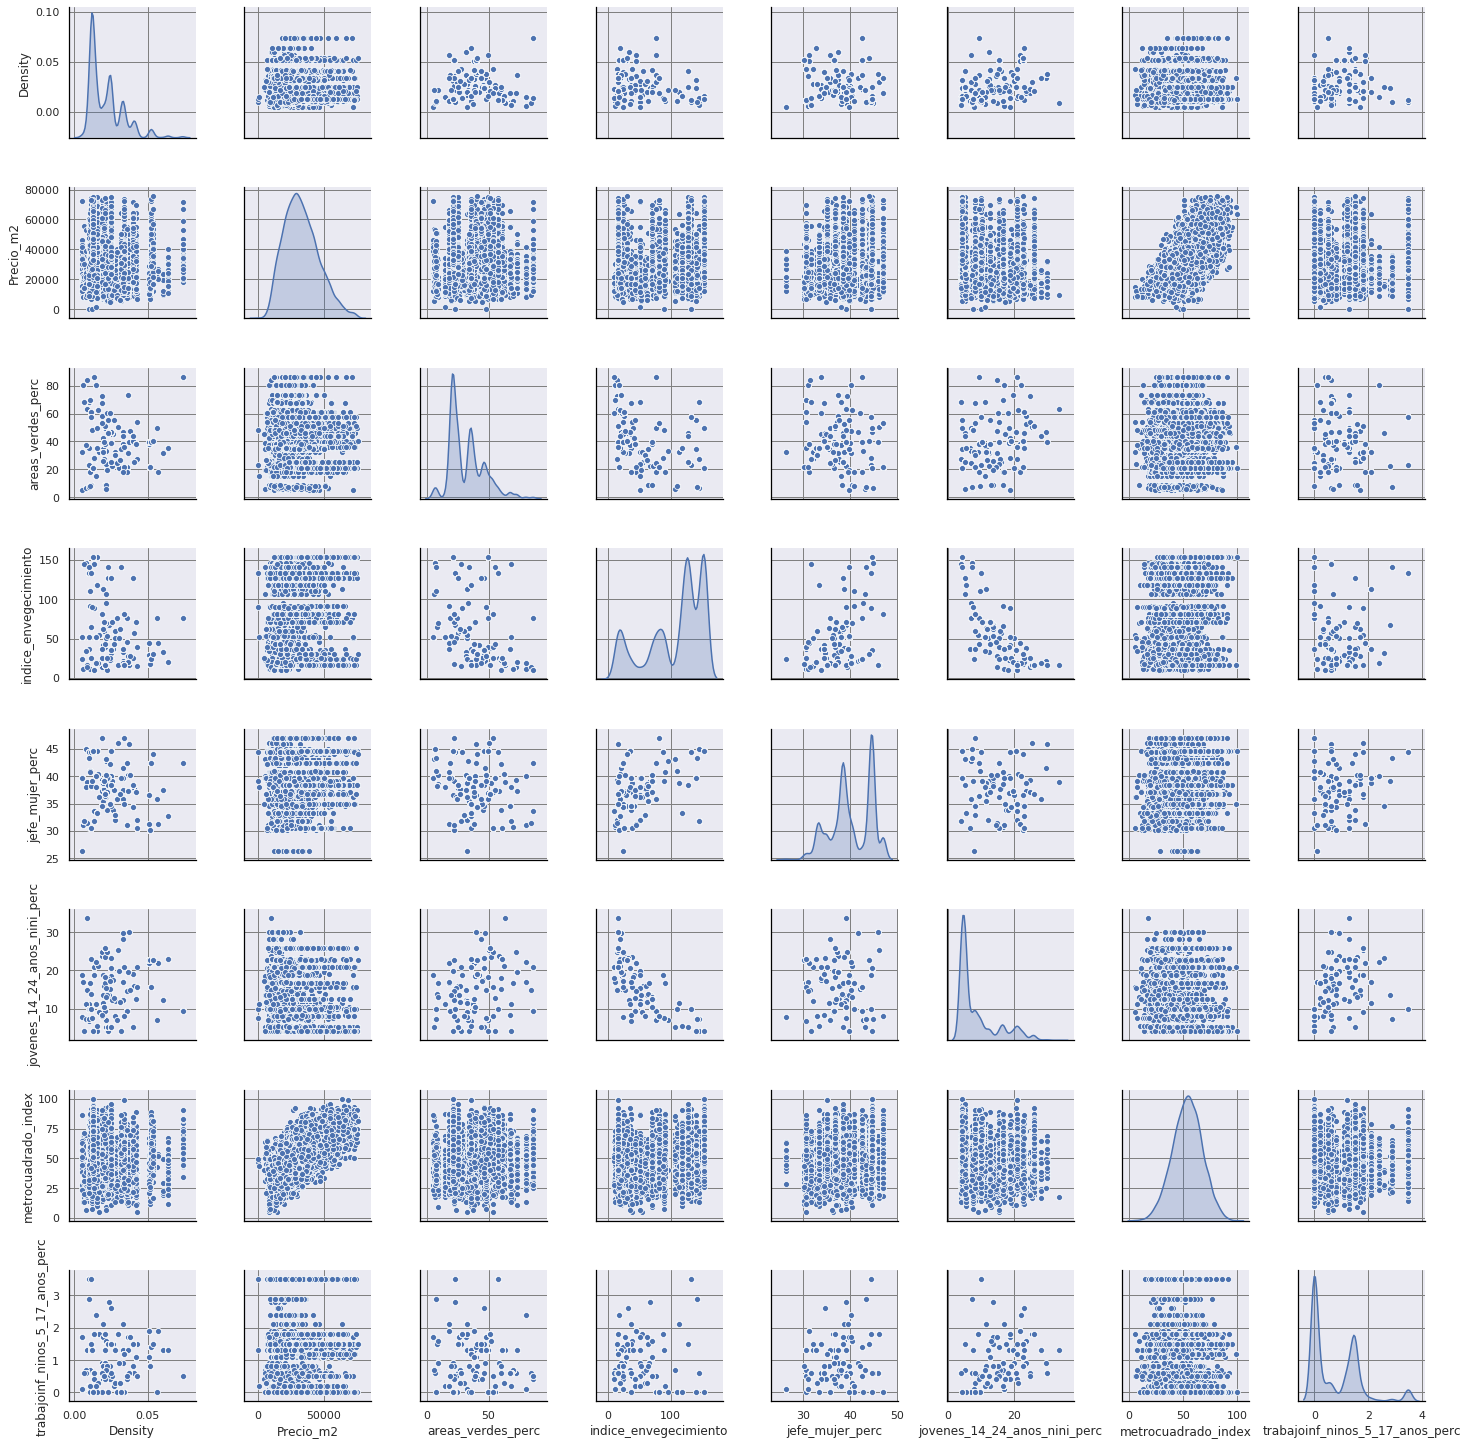

In [121]:
fig = plt.figure(figsize=(17,17))
fig.suptitle('Pairplot de las 7 Numéricas más correlacionadas con la variable de respuesta')
data = df.Numericas.copy()
sns.pairplot(data = data, diag_kind='kde')
fig.savefig('./fig/pairplot_original.pdf')

A primer vista se observan las mismas relaciones anteriores entre ``indice_envegecimiento`` y ``areas_verdes_perc``, ``jovenes-14_24_anos_nini_perc``, ``jefe_mujer_perc``.

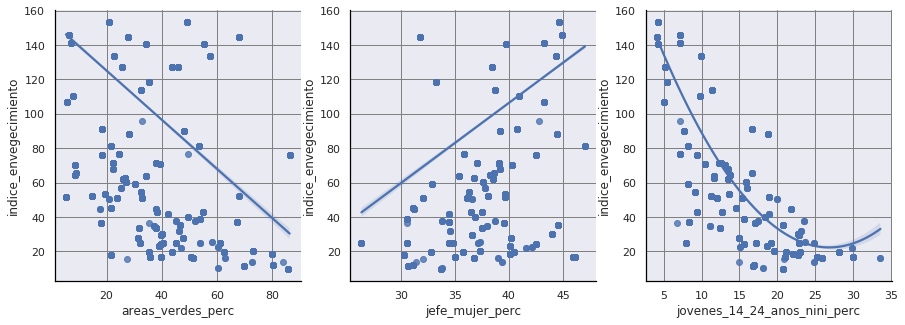

In [122]:
fig , ax = plt.subplots(1,3, figsize=(15,5))
sns.regplot(y='indice_envegecimiento', x='areas_verdes_perc', data=df.Numericas, order=1, ax=ax[0])
sns.regplot(y='indice_envegecimiento', x='jefe_mujer_perc', data=df.Numericas, order=1, ax=ax[1])
sns.regplot(y='indice_envegecimiento', x='jovenes_14_24_anos_nini_perc', data=df.Numericas, order=2, ax=ax[2])
fig.show()

A diferencia de antes, ahora la más correlacionada de entre las 4 es ``jefe_mujer_perc``, por lo que dejamos esa.

In [123]:
df.drop([('Numericas', col) for col in ['indice_envegecimiento', 'areas_verdes_perc', 'jovenes_14_24_anos_nini_perc']]
         , axis=1, inplace=True)

Text(119.59374999999999, 0.5, '')

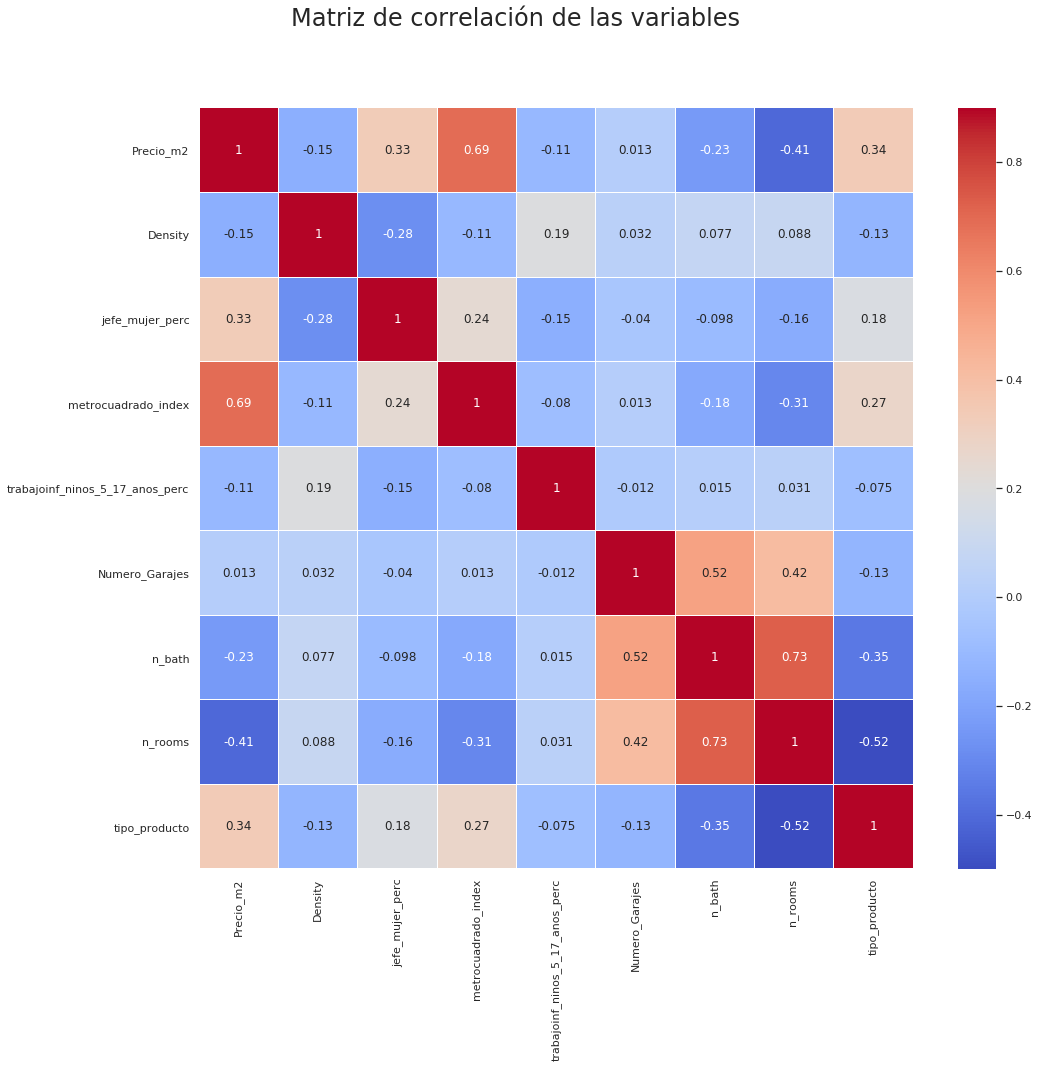

In [125]:
corrmat = df.corr()
col = indexer(['Precio_m2'], df.columns)

unsorted = list(corrmat.columns)
unsorted.remove(*col)
unsorted.insert(0, *col)

sortd = pd.MultiIndex.from_tuples(unsorted)
corrmat = corrmat.reindex(index = sortd, columns = sortd)
etiquetas=list(corrmat.columns.droplevel(0).values)

fig, ax = plt.subplots(figsize=[16, 14])
fig.suptitle('Matriz de correlación de las variables',fontsize=24, x=0.4)
ax=sns.heatmap(corrmat, vmin=-.5, vmax=.9, linewidths=.01, cmap='coolwarm', annot=True, fmt='.2g',
              yticklabels=etiquetas, xticklabels=etiquetas)
ax.set_xlabel('')
ax.set_ylabel('')
#fig.savefig('./fig/matriz_corr2.pdf', bbox_inches='tight')

6. En base a las herramientas del curso realice un análisis que permita detectar observaciones anómalas en la base de datos, justifique sus resultados, evalúe como se distribuyen los valores anómalos respecto a las variables UPZ y tipo de producto.

7. En función del análisis realizado a lo largo de esta pregunta, proponga una selección de variables que permita estimar la variable respuesta por medio de un modelo de regresión, discuta.

In [127]:
'''
Se cargan datos transformados por QuantileTransformer, llenados segun RF e IterativeImputer.
También se agruparon los codigos en UPlClusters segun los resultados de la parte 4 (3 grupos)
Cluster 1: Obs sin codigo UPZ
Cluster 2: Obs con codigo UPZ97
Cluster 0: Todos los demas
Se seleccionan variables de interes para estimar la variable de respuesta
'''
df=pd.read_pickle('./data/data_cluster.pkl')
col_interes = ['Archivo', 'property_type', 
               
               'Numero_Garajes', 'n_bath', 'n_rooms', 'tipo_producto',
               
               'Density', 'indice_envegecimiento','jefe_mujer_perc', 
               'metrocuadrado_index', 'Precio_m2', 'trabajoinf_ninos_5_17_anos_perc']
idxs = indexer(col_interes)
df=df[idxs]
df.head()
df.to_pickle('./data/data_final.pkl')

## P3. Regresión lineal bayesiana
Una vez analizado el conjunto de datos, se procede a modelar las relaciones por medio de alguna herramienta matemática. En este contexto y con las herramientas computacionales entregadas por el curso, se desarrolla un modelo de regresión lineal bayesiana, tratando el problema de modelación desde el punto vista teórico hasta su implementación e interpretación de resultados.

#### Implementación
1. Implemente la clase `RegresionBayesianaEmpirica` que herede de `BaseEstimator` y de `RegressorMixin` del módulo `sklearn.base` en la cual se implementa la heurística enunciada en la sección anterior para aproximar los hiperparámetros óptimos $\alpha$ y $\beta$. Esta clase sólo debe usar objetos de la librería `NumPy` y debe incluir al menos los siguientes métodos:
    * `__init__(self, alpha 0, beta 0, tol=1e-5, maxiter=200)`: sus argumentos son auto explicativos.
    * `get_posteriori(self, X, y, alpha, beta)`: que reciba la matriz de observaciones (`X`), el vector de etiquetas (`y`) y los hiperparámetros $\alpha$ y $\beta$. Este debe retornar los objetos necesarios para interactuar con los demás métodos.
    * `fit(self, X, y)`: que reciba la matriz de observaciones (`X`), el vector de etiquetas (`y`) e implemente el esquema de aproximación mencionado. Este método debe guardar como atributos del objeto los parámetros óptimos obtenidos, además de reportar en pantalla indicadores del proceso iterativo (incluya al menos el número de iteraciones).
    * `predict(self, X , return std=False)`: que reciba una matriz de observaciones (`X_`). Debe retornar la tupla (`y_` , `y_std`) con el vector de medias y el de desviaciones estándar (cuando `return std=True`) asociadas a las observaciones en `X`. Para esto, observe que el proceso de predicción corresponde a asignar la media posterior predictiva del modelo a nuevos puntos.
    
   Note que todo desarrollo sólo necesita de un modelo lineal en los parámetros $w$. Es decir, es posible reemplazar $X$ por una transformación (posiblemente no lineal) $\Phi(X)$, manteniendo la misma estructura distrubucional tanto en predicción como en obtención de hiperparámetros.

En las siguientes preguntas se construye un modelo de regresion en el cual debe incluir todas las variables disponibles en el conjunto de datos, reemplazando la variable de UPZ por la recategorizacion antes propuesta.

2. Construya un fujo de transformaciones sobre el conjunto datos. Por medio de la clase `Pipeline` debería:
    * Utilizar `StandardScaler` y `OneHotEncoder` donde corresponda.
    * Utilizar el objeto `PolynomialFeatures` para generar características polinomiales, en este apartado, se recomienda utilizar características de grado 3 sólo en las variables numéricas y luego concatenar con las codificaciones categóricas.
    * Generar una composición de transformaciones por medio de `ColumnTransformer`.

3. Expanda el `Pipeline` anterior agregando el modelo representado en la clase `RegresionBayesianaEmpirica`. Genere una separación de entrenamiento y test por medio de `train_test_split` del módulo `model_selection` donde el 20% de los datos sea de test. Entrene su modelo utilizando el método .fit como parámetros dentro del flujo creado por medio de Pipeline, evalúe su modelo por medio de la raíz del promedio de errores cuadráticos (_Root Mean Square Error - RMSE_. en inglés) en el conjunto de test, incluya el estadístico $R^2$.\
__Hint__: pruebe con valores para `alpha_0` y `beta_0` entre $10^{-10}$ y $10^{-5}$. Compruebe que dichos dichos hiperparametros son adecuados, al obtener un $R^2$ cercano a $0.7$.

4. Utilice su selección de variables, transfórmelas adaptando el esquema de preprocesamiento anterior, separe en conjuntos de entrenamiento y test manteniendo el 20% de proporción y evalúe los resultados del modelo `RegresionBayesianaEmpirica` incluyendo el estadístico $R^2$. Discuta.

5. Finalmente, compare los resultados de su selección de variables con los obtenidos por un pipeline donde el estimador sea uno de la clase `BayesianRidge` del módulo `sklearn.linear_model`. Discuta la diferencia de este módulo con respecto al desarrollado por ustedes.